# Adversarial Robustness



## Introduction & Setup

Adversarial examples are examples designed in order to cause a machine learning system to malfunction. In this notebook, we'll explore different ways of generating adversarial images to trick models. For an explanation of the methods we'll be working with, watch [this video lecture](https://www.youtube.com/watch?v=wIX00bZ173k) by Dan Hendrycks. You can also run the cell below to watch the video. You can also check out Section 2 of [Unsolved Problems in ML Safety](https://arxiv.org/pdf/2109.13916.pdf) for discussion of the safety motivations behind this research. 

This project is due at 5PM on Sunday by emailing a link to aisafetyusc@gmail.com. Excited to see your results!

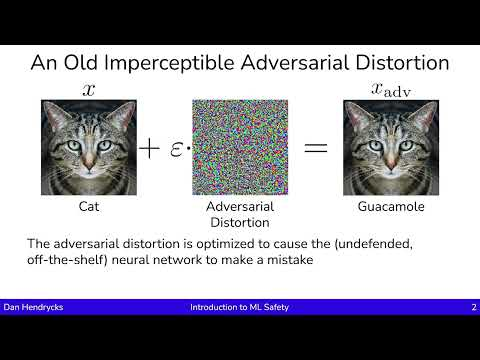

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('wIX00bZ173k')

In [ ]:
# Cloning the files from github

!git clone https://github.com/oliverzhang42/safety.git

Cloning into 'safety'...
remote: Enumerating objects: 260, done.
remote: Total 260 (delta 0), reused 0 (delta 0), pack-reused 260
Receiving objects: 100% (260/260), 177.09 MiB | 26.65 MiB/s, done.
Resolving deltas: 100% (109/109), done.
Checking out files: 100% (11/11), done.


In [ ]:
!pip3 install robustness=='1.2.1.post2'
!pip3 install torchvision=='0.10.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 95 kB 3.4 MB/s 
     |████████████████████████████████| 55 kB 4.3 MB/s 
     |████████████████████████████████| 125 kB 56.3 MB/s 
     |████████████████████████████████| 181 kB 62.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=6a6083c444fefdf234c4b3e696165bfb93b8156cc548232758c369f822165746
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built GPUtil
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.1 MB 64.9 MB/s 
     |████████████████████████████████| 831.4 MB 2.6 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:

In [ ]:
# Importing all the necessary libraries

import torch
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torchvision import models
import numpy as np


%matplotlib inline

In [ ]:
from safety.utils import utils
from safety.lesson1 import adversarial

## First Adversarial Attack using FGSM

### Untargeted FGSM

The first method we look at is the untargeted Fast Gradient Sign Method (FGSM) proposed by [Goodfellow et al.](https://arxiv.org/pdf/1412.6572.pdf). 

The attack constructs adversarial examples as follows:

$$x_\text{adv} = x + \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y))$$

where 

*   $x_\text{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y$ : Original input label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

This method takes the gradient of each pixel in the input with respect to the loss. Then it takes the sign of each pixel's gradient, and multiplies it by epsilon. This epsilon-sized update in the direction of the gradient will be added to the original input image, resulting in a new image with higher loss.

The current attack formulation is considered 'untargeted' because it only seeks to maximize loss rather than to trick the model into predicting a specific label. 


Try implementing the untargeted FGSM method for a batch of images yourself!

In [ ]:
def untargeted_FGSM(x_batch, true_labels, network, normalize, eps=8/255., **kwargs):
  """Generates a batch of untargeted FGSM adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of unnormalized input examples.
    true_labels (torch.Tensor): the batch of true labels of the example.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    eps (float): the bound on the perturbations.
  """
  loss_fn = nn.CrossEntropyLoss(reduce="mean")
  x_batch.requires_grad = True
  
  # x_ad=torch.cuda.FloatTensor(3,7,10)
  network.zero_grad()
  outputs=network(x_batch)
  loss = loss_fn(outputs,true_labels)
  loss.backward()
  x_adv_grad=x_batch.grad
  x_adv_grad_sign=x_adv_grad.sign()
  x_adv=x_batch+eps*x_adv_grad_sign

  return x_adv

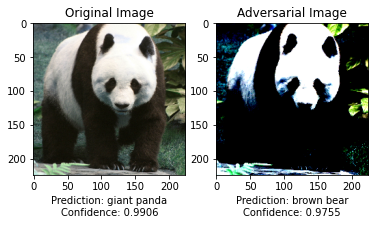

In [ ]:
# Test the method
adversarial.test_untargeted_attack(untargeted_FGSM, eps=8/255.)

If things go well, the model should switch from predicting 'giant panda' to predicting 'brown bear' or some other class. Additionally, try increasing the epsilon to see the noise more clearly.

### Targeted FGSM

In addition to the untargeted FGSM which simply seeks to maximize loss, we can also create targeted adversarial attacks. We do this using the following equation:

$$x_{adv} = x - \epsilon\cdot\text{sign}(\nabla_xJ(\theta, x, y_{target}))$$

where 

*   $x_{adv}$ : Adversarial image.
*   $x$ : Original input image.
*   $y_{target}$ : The target label.
*   $\epsilon$ : Multiplier to ensure the perturbations are small.
*   $\theta$ : Model parameters.
*   $J$ : Loss.

The targeted attack replaces the true label with a target label, then updates the input pixels in the direction that maximizes the probability of the target label. 

Try implementing the targeted FGSM method for a batch of images yourself!

In [ ]:
def targeted_FGSM(x_batch, target_labels, network, normalize, eps=8/255., **kwargs):
  """Generates a batch of targeted FGSM adversarial examples

  Args:
    x_batch (torch.Tensor): the unnormalized input example.
    target_labels (torch.Tensor): the labels the model will predict after the attack.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    eps (float): the bound on the perturbations.
  """
  loss_fn = nn.CrossEntropyLoss(reduce="mean")
  x_batch.requires_grad = True
  network.zero_grad()
  outputs=network(x_batch)
  loss = loss_fn(outputs,target_labels)
  loss.backward()
  x_adv_grad=x_batch.grad
  x_adv_grad_sign=x_adv_grad.sign()
  x_adv=x_batch-eps*x_adv_grad_sign

  #########################
  # Enter Your Code Here! #
  #########################
  
  return x_adv

**Note that even if the implementation is perfect, FGSM is not able to generate effective targeted attacks, so don't expect the output image to assign a high probability to the target label.**


The target index corresponds to a label of hen!


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


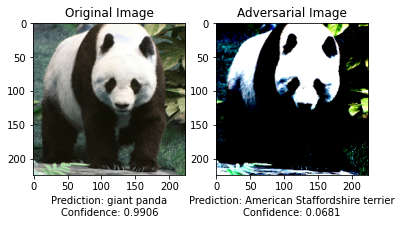

In [ ]:
adversarial.test_targeted_attack(targeted_FGSM, target_idx=8, eps=8/255.)

## Second Attack: Projected Gradient Descent

Now let's try Projected Gradient Descent (PGD), a technique developed by [Madry et al.](https://arxiv.org/pdf/1706.06083.pdf). As mentioned in the video lecture, PGD is a stronger version of FGSM, which applies multiple FGSM steps to ascend the loss gradient. We provide both targeted and untargeted versions.



We will implement some helper functions that we can use for the Projected Gradient Descent (PGD) L2 method below.

First, let's write a helper function to calculate the L2 norm of an image. If you're unfamiliar with what an L2 norm is, [this link](https://towardsdatascience.com/a-quick-guide-to-understanding-vectors-norms-84eb802f81f9) has more information. The normalize_l2 function will be returning the following value, given an input image:

$$\frac{x}{||x||_{2}}$$

We're doing this in batches, so the function will be given a batch of input images, and you'll return a batch of the L2 norms. Try to use native PyTorch functions for this -- there's no need to use any loops. 

In [ ]:
def normalize_l2(x_batch):
    """
    Expects x_batch.shape == [N, C, H, W]
    where N is the batch size, 
    C is the channels (or colors in our case),
    H, W are height and width respectively.

    Note: To take the l2 norm of an image, you will want to flatten its dimensions (be careful to preserve the batch dimension of x_batch).
    """
    x_batch_flatten=x_batch.flatten(start_dim=1)
    # print (x_batch_flatten.shape)
    x_batch_norm=torch.linalg.vector_norm(x_batch_flatten, ord=2,keepdim=True)
    # print (x_batch_flatten.shape)
    x_adv=x_batch/x_batch_norm
    # print (x_batch_flatten.shape)


    #########################
    # Enter Your Code Here! #
    #########################

    return x_adv

Now let's implement a helper function to clamp the adversarial images outputted at each FGSM step, so they don't stray too far from the original example. 

[Clamping](https://pytorch.org/docs/stable/generated/torch.clamp.html) is the "clip" operation referred to at [9:23 in the video lecture](https://youtu.be/wIX00bZ173k?t=563). This operation ensures that each element in the adversarial image tensor outputted by the FGSM step is less than $ϵ$ away from the equivalent element in the original image. 

For the tensor_clamp_l2 function we will compute and return the following value

\begin{equation}
    X=
    \begin{cases}
      clamp(x), & \text{if}\ ||x-x_{orig}||_2 > ϵ \\
      x, & \text{otherwise}
    \end{cases}
  \end{equation}

where 
$ \text{clamp}(x) = x_{orig} + \frac{x-x_{orig}}{||x-x_{orig}||_2} ⋅ \epsilon $, X is the return value, x is the adversarial image tensor to be clamped, $x_{orig}$ is the original image tensor, and ϵ is a scalar value denoting how far from the original image you want the adversarial image to be.

In [ ]:
def tensor_clamp_l2(x_adv_batch, x_orig_batch, epsilon):
    """In batches, clamp x_adv to within a distance epsilon of x_orig."""
    x_adv_batch_flatten=x_adv_batch.flatten(start_dim=1)
    # print (x_adv_batch_flatten.shape)
    x_orig_batch_flatten=x_orig_batch.flatten(start_dim=1)
    # print (x_orig_batch_flatten.shape)
    x_difference=x_adv_batch-x_orig_batch
    x_difference_norm=x_adv_batch_flatten-x_orig_batch_flatten
    x_norm=torch.linalg.vector_norm(x_difference_norm, ord=2, keepdim=True)

    if x_norm>epsilon:
      x_adv=x_orig_batch+(normalize_l2(x_difference)*epsilon)
    else:
      x_adv=x_adv_batch
    #########################
    # Enter Your Code Here! #
    #########################

    return x_adv

The function below is the full PGD function, which utilizes the helper functions you just wrote.

In [ ]:
def PGD_l2(x_batch, true_labels, network, normalize, num_steps=20, step_size=3./255, eps=128/255., **kwargs):
        """
        :return: perturbed batch of images
        """
        # Initialize our adversial image
        x_adv = x_batch.detach().clone()
        # print (x_adv.shape)
        x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

        for _ in range(num_steps):
            x_adv.requires_grad_()
            
            # Calculate gradients
            with torch.enable_grad():
              logits = network(normalize(x_adv))
              loss = F.cross_entropy(logits, true_labels, reduction='sum')

            # Normalize the gradients with your L2
            grad = normalize_l2(torch.autograd.grad(loss, x_adv, only_inputs=True)[0])

            # Take a step in the gradient direction.
            x_adv = x_adv.detach() + step_size * grad

            # Clamp the adversarial image to within a distance epsilon from the 
            # original image.

            x_adv = tensor_clamp_l2(x_adv, x_batch, eps).clamp(0, 1)

        return x_adv

Try out the helper functions you wrote. Note how the hyperparameters differ depending on the attack that one is using. You can see more examples below.


torch.Size([1, 3, 224, 224])


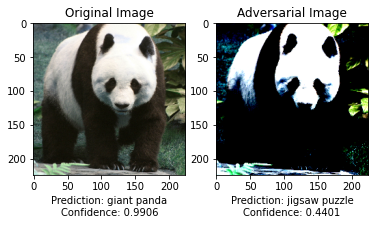

In [ ]:
adversarial.test_untargeted_attack(PGD_l2, eps=128/255.)

Finally, here's the full untargeted and targeted implementations of the PGD method. 

In [ ]:
def untargeted_PGD(x_batch, true_labels, network, normalize, num_steps=10, step_size=0.01, eps=8/255., **kwargs):
  """Generates a batch of untargeted PGD adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of unnormalized input examples.
    true_labels (torch.Tensor): the batch of true labels of the example.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    num_steps (int): the number of steps to run PGD.
    step_size (float): the size of each PGD step.
    eps (float): the bound on the perturbations.
  """
  x_adv = x_batch.detach().clone()
  x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

  for i in range(num_steps):
    print(f'Step {i}')
    x_adv.requires_grad_()
    
    # Calculate gradients
    with torch.enable_grad():
      logits = network(normalize(x_adv))
      loss = F.cross_entropy(logits, true_labels, reduction='sum')
    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    
    # Perform one gradient step
    x_adv = x_adv.detach() + step_size * torch.sign(grad.detach())
    
    # Project the image to the ball.
    x_adv = torch.maximum(x_adv, x_batch - eps)
    x_adv = torch.minimum(x_adv, x_batch + eps)

  return x_adv


Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9


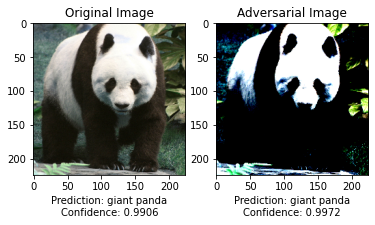

In [ ]:
adversarial.test_untargeted_attack(untargeted_PGD, eps=8/255.)

In [ ]:
def targeted_PGD(x_batch, target_labels, network, normalize, num_steps=100, step_size=0.01, eps=8/255., **kwargs):
  """Generates a batch of untargeted PGD adversarial examples

  Args:
    x_batch (torch.Tensor): the batch of preprocessed input examples.
    target_labels (torch.Tensor): the labels the model will predict after the attack.
    network (nn.Module): the network to attack.
    normalize (function): a function which normalizes a batch of images 
        according to standard imagenet normalization.
    num_steps (int): the number of steps to run PGD.
    step_size (float): the size of each PGD step.
    eps (float): the bound on the perturbations.
  """
  x_adv = x_batch.detach().clone()
  x_adv += torch.zeros_like(x_adv).uniform_(-eps, eps)

  for i in range(num_steps):
    x_adv.requires_grad_()
    
    # Calculate gradients
    with torch.enable_grad():
      logits = network(normalize(x_adv))
      loss = F.cross_entropy(logits, target_labels, reduction='sum')
    grad = torch.autograd.grad(loss, x_adv, only_inputs=True)[0]
    
    # Perform one gradient step
    # Note that this time we use gradient descent instead of gradient ascent
    x_adv = x_adv.detach() - step_size * torch.sign(grad.detach())
    
    # Project the image to the ball
    x_adv = torch.maximum(x_adv, x_batch - eps)
    x_adv = torch.minimum(x_adv, x_batch + eps)
  
  return x_adv


The target index corresponds to a label of goldfish!


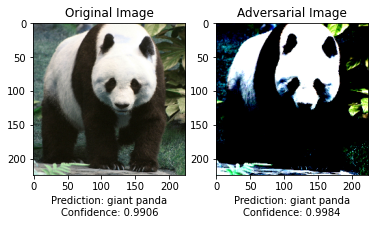

In [ ]:
# Try changing the target_idx around!
adversarial.test_targeted_attack(targeted_PGD, target_idx=1, eps=8/255.)

# Congrats! You've successfully broken a neural net. 

You might wonder, how can we make models robust to adversarial examples?
* We can train on adversarial examples, e.g. [here](https://openaccess.thecvf.com/content_CVPR_2020/papers/Xiao_One_Mans_Trash_Is_Another_Mans_Treasure_Resisting_Adversarial_Examples_CVPR_2020_paper.pdf)
* We can detect adversarial examples and simply reject them, e.g. [here](https://openaccess.thecvf.com/content_ICCV_2017/papers/Lu_SafetyNet_Detecting_and_ICCV_2017_paper.pdf)
* We can reconstruct images before classification, e.g. [here](https://openaccess.thecvf.com/content_CVPR_2019/papers/Jia_ComDefend_An_Efficient_Image_Compression_Model_to_Defend_Adversarial_Examples_CVPR_2019_paper.pdf)
* We can highlight salient features in image, e.g. [here](https://openaccess.thecvf.com/content_CVPR_2019/papers/Xie_Feature_Denoising_for_Improving_Adversarial_Robustness_CVPR_2019_paper.pdf)
* And [much more](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=adversarial+robustness&btnG=)! Feel free to check out other kinds of adversarial attacks or robustness strategies. We'll have time at the beginning of next week's meeting for people to briefly explain any cool new methods they found. 

Well done on your first project. Don't forget to email us a link, and see you on Monday! 